In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate
from pulse_pair_doppler import chirp, pulse_pairs, random_receive, delayed_correlation

In [4]:
# TODO add motion to point scatterers

T0 = 0e-3 # s
Te = 1e-3 # s
B_c = 1e6 # hz
f =  5.405e9 # hz
over_sample = 1 # -
receive_time = 30e-3 # Te*10
n_reflectors = 10000 #

T_pulse=Te-T0 # s
T_interpulse=0 # s (Te-T0)/4
n_pulses=2 # -

k_c = B_c/Te # hz/s
fs_nyq = 2*(f + 2*B_c) # hz, times 2 to follow Nyquist
fs = fs_nyq * over_sample # hz
s = 1/fs # stepsize
t = np.arange(T0, (Te + s), s) # s
receive_samples = int(receive_time*fs )

In [5]:
# generate a single pulse for the pulse pair
pulse = chirp(t, f, k_c) 

# combine multiple pulses into a pulse pair
signal, t_signal, samples_interpulse = pulse_pairs(
    pulse=pulse, 
    T_pulse=T_pulse, 
    T_interpulse=T_interpulse, 
    n_pulses=n_pulses)

phase = np.arctan2(signal.imag, signal.real)

# calculate the reflection of pulse pair from random arrangement of point scatterers
reflections = random_receive(
    n_reflectors = n_reflectors,
    return_window = receive_samples,
    signal = signal
    )
reflections = np.ravel(reflections)

# compute pulse compressed return using fft compression
taper = np.hamming(len(pulse))
pulse_compress = correlate(reflections, taper*pulse, mode = "same", method = "fft")

# calculate delayed cross correlation 
corr_pulse_compress, corr_peak_pulse_compress =  delayed_correlation(
    signal_received=pulse_compress, 
    signal_length=len(pulse), 
    inter_signal_delay=samples_interpulse)

# organize data to show in box plot
data = corr_peak_pulse_compress * 1/fs

100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


/Users/opodriscoll/miniconda3/envs/env_stereoid/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Interpulse correlation delay (input $\\Delta T$: 0.001)')

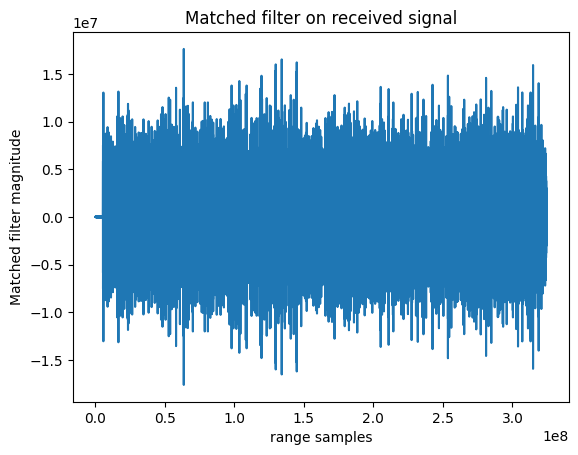

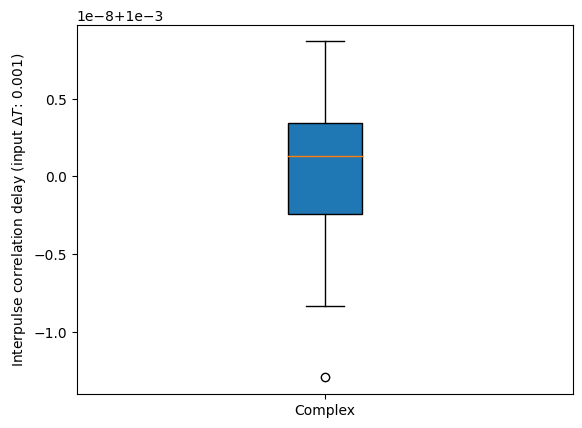

In [6]:
plt.figure()
plt.title('Matched filter on received signal')
plt.plot(pulse_compress)
plt.xlabel("range samples"); plt.ylabel("Matched filter magnitude")

# NOTE in the figure below we alreadyremove the delay caused by the interpulse time
plt.figure()
plt.boxplot(data,vert=True, patch_artist=True, labels = ['Complex'])
plt.ylabel(f"Interpulse correlation delay (input $\Delta T$: {T_pulse})")